# XGBoosting Regression
The official documentation can be found here:
https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn.

good blog: https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb

Hyperparam tuning: https://medium.com/@silvaan/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a

## Importing the libraries

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
 

from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Paper 13/paper13.csv')
df.head()

,Biomass type,Reactor/feeding,VS (%),pH,OLR (g VS/l.d),HRT (d),T (°C),Reactor Volume (m³),Cumulated biogas volume (L/(g VS))
0,0,0,10.00,7.62,0.6270,19.2,55,0.0500,0.0668
1,0,2,15.30,8.00,3.1702,47.0,37,0.0473,0.6765
2,0,0,4.78,7.25,1.2400,15.0,37,0.0450,0.8227
3,0,0,4.78,7.25,1.7600,15.0,37,0.0450,0.6219
4,0,2,6.36,7.30,3.2000,25.0,35,0.0400,0.5755


## Dropping columns 
Since EDA points out that 
1. Biomass Type,   
2. OLR   
3. Reactor Volume   
are not strongly corelated with the output, they can be dropped.  

In [32]:
# df.drop(columns=['Reactor Volume (m³)'], inplace=True)
# df.head()

## Outlier Detection and Removal
### 1. Temperature

In [33]:
# percentile25 = df['T (°C)'].quantile(0.25)
# percentile75 = df['T (°C)'].quantile(0.75)

# iqr = percentile75 - percentile25
# upper_limit = percentile75 + 1.5 * iqr
# lower_limit = percentile25 - 1.5 * iqr

# print(upper_limit)
# print(lower_limit)

# # Removing outliers
# df = df[df['T (°C)'] <= 50]

# df.shape

## 2. VS%

In [34]:
# percentile25 = df['VS (%)'].quantile(0.25)
# percentile75 = df['VS (%)'].quantile(0.75)

# iqr = percentile75 - percentile25
# upper_limit = percentile75 + 1.5 * iqr
# lower_limit = percentile25 - 1.5 * iqr

# print(upper_limit)
# print(lower_limit)

# # Removing outliers
# df = df[df['VS (%)'] <= upper_limit]

# df.shape

## 3. HRT


In [35]:
# percentile25 = df['HRT (d)'].quantile(0.25)
# percentile75 = df['HRT (d)'].quantile(0.75)

# iqr = percentile75 - percentile25
# upper_limit = percentile75 + 1.5 * iqr
# lower_limit = percentile25 - 1.5 * iqr

# print(upper_limit)
# print(lower_limit)

# Removing outliers
# new_df = df[df['VS (%)'] > upper_limit]

# new_df.shape
# These outliers were removed as part of the VS% outliers

## 4. OLR

In [36]:
# # Using the percentile method of outlier removal

# upper_limit = df['OLR (g VS/l.d)'].quantile(0.99)
# lower_limit = df['OLR (g VS/l.d)'].quantile(0.01)

# print(upper_limit)
# print(lower_limit)

# # Removing outliers
# df = df[df['OLR (g VS/l.d)'] <= upper_limit]

# df.shape
# df.head()

## Splitting the data into Test and training data

In [37]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Cumulated biogas volume (L/(g VS))'])
y = df['Cumulated biogas volume (L/(g VS))']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

# Pipeline information

(Since this data does not have missing values, not imputation is required.)

The following transformers will be applied in the pipeline.

Step 1: OneHotEncoding the categorical columns. 

Step 2: Scaling using StandardScaler

Step 3: Training

(We could have added feature selection before training as well)

Note: After OneHot Encoding, the number of columns becomes:  
5 (for reactor/feeding)  
\+ 4

= 9




In [38]:
# 1. One Hot Encoding
trf0 = ColumnTransformer(transformers = [
    ('ohe0', OneHotEncoder(), ['Reactor/feeding', 'Biomass type'])
], remainder='passthrough')

In [39]:
# 2. Scaling
#  Scaling only the temperature column
trf2 = ColumnTransformer([
    ('scale', StandardScaler(), slice(2,10)) # No OHE, 2 categorical vairables
    # ('scale', StandardScaler(), slice(1,10)) # No OHE, 1 categorical vairable
    # ('scale', StandardScaler(), slice(8,15)) # With OHE, 2 categorical vairable
], remainder = 'passthrough')

In [40]:
# 3. Transformation

# The slicing column numbers have to be changed since after the first transformation, the columns are reordered.
trf3 = ColumnTransformer([
    ('transform', PowerTransformer(), slice(2,10))
], remainder='passthrough') 

In [41]:
# 3. Training
trf4 = XGBRegressor(random_state = 0, objective='reg:squarederror', n_estimators = 100, max_leaves=0, max_depth=3, learning_rate = 0.1, booster = 'gbtree')


## Creating the pipeline

In [42]:
pipe = Pipeline([
    # ('ohe0', trf0),
    ('scaling', trf2),
    # ('transform', trf3),
    ('xgb', trf4),
])

## Training and predicting using the pipeline

Here we are using default parameters

In [43]:
# Display Pipeline

from sklearn import set_config
set_config(display='diagram')
# Show the steps involved in the pipeline
pipe.named_steps

# train and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
r2_score(y_test, y_pred)

# Visualize 
# X_trans = pipe.fit_transform(X_train)
# X_pd = pd.DataFrame(X_trans)
# X_pd.head()

0.8227325760346758

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


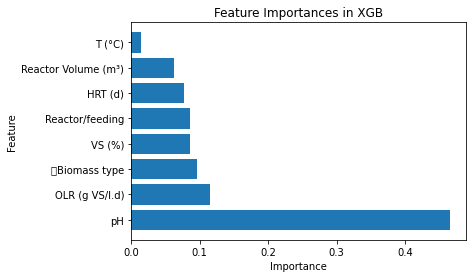

In [44]:
# Get the feature importance scores
importances = trf4.feature_importances_

importances.shape
# Create a dataframe of feature importances
feature_importances = pd.DataFrame({"feature": ["	Biomass type",	"Reactor/feeding",	"VS (%)",	"pH",	"OLR (g VS/l.d)",	"HRT (d)",	"T (°C)",	"Reactor Volume (m³)"], 
                                    "importance": importances})

# Sort the dataframe by importance
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Plot the feature importances
plt.barh(feature_importances["feature"], feature_importances["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in XGB")
plt.show()

## GridSearch using the pipeline
1. n_estimators: Number of gradient boosted trees. Equivalent to number of boosting rounds.
2. max_depth: Max tree depth for base learners. Defaults to 3. (Better to keep it under 10.)
3. Objective functions: [This](https://machinelearningmastery.com/xgboost-loss-functions/) provides a good explanation. Functions that can be used: 'reg:squarederror', 'reg:logistic', 'reg:gamma', and 'reg:tweedie'
4. Max Leaves: 0 indicates no leaves. From notes: a good range is from 8 to 32.
5. Learning rate: "It is common to have small values in the range of 0.1 to 0.3, as well as values less than 0.1." [Here](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/)


In [ ]:
# gridsearchcv
params = {
    'xgb__random_state':[0],
    'xgb__objective':['reg:squarederror'],
    'xgb__n_estimators':[ 10, 50, 100],
    'xgb__max_depth':[5, 10, 50],
    'xgb__max_leaves':[0],
    'xgb__learning_rate':[0.001, 0.1, 0.3],
    'xgb__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'xgb__gamma': [i/10.0 for i in range(3)],
    'xgb__reg_alpha':[0,1,5],
    'xgb__reg_lambda':[0,1,5],
    'xgb__booster':['gbtree', 'dart']
}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=10, scoring='r2')
grid.fit(X, y)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ohe0',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe0',
                                                                         OneHotEncoder(),
                                                                         ['Reactor/feeding',
                                                                          'Biomass '
                                                                          'type'])])),
                                       ('scaling',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         slice(8, 15, None))])),
                                       ('xgb',
                                        XGBRegressor(max_leaves=0,
                                                     objective='reg:squarederror'))]),
             param_grid={'xgb__booster': ['gbtree', 'dart'],
                         'xgb__colsample_bytree': [0.1, 0.2],
                         'xgb__gamma': [0.0, 0.1, 0.2],
                         'xgb__learning_rate': [0.001, 0.1, 0.3],
                         'xgb__max_depth': [5, 10, 50], 'xgb__max_leaves': [0],
                         'xgb__n_estimators': [10, 50, 100],
                         'xgb__objective': ['reg:squarederror'],
                         'xgb__random_state': [0], 'xgb__reg_alpha': [0, 1, 5],
                         'xgb__reg_lambda': [0, 1, 5]},
             scoring='r2')

# GridSearchCV results


In [ ]:
grid.best_score_

0.6126965128268095

In [ ]:
grid.best_params_

{'xgb__booster': 'dart',
 'xgb__colsample_bytree': 0.2,
 'xgb__gamma': 0.0,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__max_leaves': 0,
 'xgb__n_estimators': 100,
 'xgb__objective': 'reg:squarederror',
 'xgb__random_state': 0,
 'xgb__reg_alpha': 0,
 'xgb__reg_lambda': 0}

# Important Results:

### a. Nothing dropped, no scaling
1. r2_score = **0.8227**
2. cv_score =  0.4933
3. `best params = {'rf__criterion': 'squared_error',
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 1000}`

### b. Nothing dropped, WITH scaling on non categorical data
1. r2_score = **0.8227** (same as no scaling)
2. cv_score =  0.5974
3. `best params = {'xgb__booster': 'gbtree',
 'xgb__learning_rate': 0.3,
 'xgb__max_depth': 3,
 'xgb__max_leaves': 0,
 'xgb__n_estimators': 50,
 'xgb__objective': 'reg:squarederror',
 'xgb__random_state': 0}`

### c. Biomass type, OLR and reactor volume have been dropped
1. r2_score = 0.5956
2. cv_score =  0.4944
3. `best params = {'xgb__booster': 'dart',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__max_leaves': 0,
 'xgb__n_estimators': 100,
 'xgb__objective': 'reg:squarederror',
 'xgb__random_state': 0}`

### d. Biomass type and reactor volume have been dropped

1. r2_score = **0.8089** (This shows that OLR is important.)
2. cv_score =  0.5726
3. `best params = {'xgb__booster': 'gbtree',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__max_leaves': 0,
 'xgb__n_estimators': 100,
 'xgb__objective': 'reg:squarederror',
 'xgb__random_state': 0}`

### e. Biomass type has been dropped

1. r2_score = **0.8223**
2. cv_score =  0.5966
3. `best params = {'xgb__booster': 'dart',
 'xgb__learning_rate': 0.3,
 'xgb__max_depth': 3,
 'xgb__max_leaves': 0,
 'xgb__n_estimators': 50,
 'xgb__objective': 'reg:squarederror',
 'xgb__random_state': 0}`

### f. Reactor volume has been dropped

1. r2_score = **0.7815**
2. cv_score =  0.5639
3. `best params = {'xgb__booster': 'gbtree',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__max_leaves': 0,
 'xgb__n_estimators': 100,
 'xgb__objective': 'reg:squarederror',
 'xgb__random_state': 0}`

## BEST Results (without outlier removal):
Biomass Type dropped.   
r2_score = **0.8223**  
cv_score =  0.5966

## Outlier removal

1. Temperature: The results were significantly worse.  
  r2_score = 0.6484  
  cv_score = 0.4879  

2. VS% : The CV score improved.  
  r2_score = **0.8084**  
  cv_score = 0.6260

3. OLR and VS%:  
  r2_score = **0.8206**  
  cv_score = 0.6351

**Best results WITH outlier removal**  
  r2_score = **0.8206**   
  cv_score = 0.6351


  `{'xgb__booster': 'dart',
 'xgb__colsample_bytree': 0.2,
 'xgb__gamma': 0.0,
 'xgb__learning_rate': 0.3,
 'xgb__max_depth': 5,
 'xgb__max_leaves': 0,
 'xgb__n_estimators': 100,
 'xgb__objective': 'reg:squarederror',
 'xgb__random_state': 0,
 'xgb__reg_alpha': 0,
 'xgb__reg_lambda': 1}`
